In [12]:
# (Only first-session commands!)
!mkdir data
!cd data
# download Large Movie Review Dataset as archive:
!curl --output large_movie_review_dataset.tar.gz https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# unzip dataset:
!gzip -d large_movie_review_dataset.tar.gz
!tar -xf large_movie_review_dataset.tar
# move files from aclImdb dir -> just data:
!mv aclImdb/* data/
# remove empty aclImdb dir:
!rm -r aclImdb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  5583k      0  0:00:14  0:00:14 --:--:-- 12.6M


In [ ]:
# Setup ENV
!pip3 install virtualenv
!virtualenv temp_venv
!source temp_venv/bin/activate
!pip install numpy==1.26
!pip install evaluate
!pip install emoji
!pip install numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 21.3 MB/s eta 0:00:00
created virtual environment CPython3.12.11.final.0-64 in 999ms
  creator CPython3Posix(dest=/content/temp_venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==25.2
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 39.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is th

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 37.7 MB/s eta 0:00:00


In [2]:
# Imports
import DistilBERT_FineTuning_dataset_creation as ft_ds
from sklearn.model_selection import train_test_split
import pandas as pd
import additional_functions_for_data_preprocessing as ad_fncs
from datasets import DatasetDict, Dataset
from google.colab import drive
import os
from numba import cuda
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import TrainerCallback
from transformers import create_optimizer
import evaluate
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
import torch
import matplotlib.pyplot as plt

In [25]:
# (Only first-session commands! But if need to recreate dataset from scratch - you are welcome)
# Train, Validation, Test datasets creation for DistilBERT fine-tuning
datasets_files_info = {
    "train": {
        "positive_reviews_path": 'data/train/pos',
        "negative_reviews_path": 'data/train/neg'
    },
    "test": {
        "positive_reviews_path": 'data/test/pos',
        "negative_reviews_path": 'data/test/neg'
    }
}

datasets_save_path = "."
class_samples_amount = 8000  # by default - entire dataset - just delete this var from main calling.

def main(datasets_files: dict, save_path: str, class_samples_amount = 'all', oversample_neutral_reviews = True):
    datasets = get_datasets_from_reviews_files(datasets_files, class_samples_amount)
    target_dataset_for_split = get_merged_train_test_datasets_into_one(datasets)
    dataset_with_neutral_reviews = include_neutral_reviews_to_result_dataset(
        target_dataset_for_split
    )
    train_val_test_datasets = get_train_validation_test_datasets(
        dataset_with_neutral_reviews
    )
    if oversample_neutral_reviews:
      neutral_reviews_distribution_in_datasets = get_neutral_reviews_distribution_in_datasets(
          train_val_test_datasets
      )
      neutral_reviews_oversampling_coeffs = get_neutral_reviews_oversampling_coeffs_for_datasets(
          train_val_test_datasets, neutral_reviews_distribution_in_datasets
      )
      neutral_reviews_oversampled_datasets = get_neutral_reviews_oversampled_datasets(
          train_val_test_datasets,
          neutral_reviews_distribution_in_datasets,
          neutral_reviews_oversampling_coeffs
      )
    print('Train Neutral Reviews Amount:', neutral_reviews_oversampled_datasets['train'][neutral_reviews_oversampled_datasets['train']['label'] == 2].shape)
    print('Train Negative Reviews Amount:', neutral_reviews_oversampled_datasets['train'][neutral_reviews_oversampled_datasets['train']['label'] == 0].shape)
    print('Train Positive Reviews Amount:', neutral_reviews_oversampled_datasets['train'][neutral_reviews_oversampled_datasets['train']['label'] == 1].shape)
    converted_train_val_test_datasets = get_converted_datasets_into_DatasetDict_Dataset(
        neutral_reviews_oversampled_datasets
    )
    save_train_val_test_datasets_to_disk(
        converted_train_val_test_datasets, save_path
    )

def save_train_val_test_datasets_to_disk(datasets: DatasetDict, save_path: str):
    datasets.save_to_disk(
        dataset_dict_path = save_path,
        storage_options = {}
    )
    print('Train, Validation, Test datasets saved.')

def get_train_validation_test_datasets(target_dataset: pd.DataFrame):
    train_dataset_for_split, test_dataset = train_test_split(
        target_dataset, test_size = 0.1, shuffle = True
    )
    train_dataset, validation_dataset = train_test_split(
        train_dataset_for_split, train_size = 0.92, shuffle = True
    )
    return {
        "train": train_dataset,
        "validation": validation_dataset,
        "test": test_dataset
    }

def get_converted_datasets_into_DatasetDict_Dataset(datasets: dict[pd.DataFrame]):
    for dataset in datasets:
        datasets[dataset] = Dataset.from_pandas(
            datasets[dataset], preserve_index = False
        )
    return DatasetDict(datasets)

def get_datasets_from_reviews_files(
datasets_files_info: dict, class_samples_amount) -> dict[pd.DataFrame]:
    if class_samples_amount != 'all':
        class_samples_amount_per_dataset_type = class_samples_amount // 2
    else:
        class_samples_amount_per_dataset_type = class_samples_amount
    result_datasets = {}
    for dataset_type in datasets_files_info:
        dataset_creation = ft_ds.DistilBERT_Fune_Tuning_Dataset_Creation(
            datasets_files_info[dataset_type]["positive_reviews_path"],
            datasets_files_info[dataset_type]["negative_reviews_path"]
        )
        result_datasets[dataset_type] = dataset_creation.main(class_samples_amount_per_dataset_type)
    return result_datasets

def get_merged_train_test_datasets_into_one(
train_test_datasets: dict[pd.DataFrame]) -> pd.DataFrame:
    target_dataset_for_splitting = pd.concat(
        [train_test_datasets["train"], train_test_datasets["test"]],
        axis = 0, ignore_index = True
    )
    return target_dataset_for_splitting

def include_neutral_reviews_to_result_dataset(res_dataset: pd.DataFrame):
    neutral_reviews_df = pd.read_json(
        "neutral_reviews.json", orient = 'records', lines = True
    )
    neutral_reviews_df['label'] = 2
    reviews_3_types_dataset = pd.concat(
        [res_dataset, neutral_reviews_df],
        axis = 0, ignore_index = True
    )
    return reviews_3_types_dataset

def get_neutral_reviews_oversampled_datasets(datasets: dict[pd.DataFrame],
neutral_reviews_distribution: dict, neutral_reviews_oversampling_coeffs: dict) -> pd.DataFrame:
  for dataset_type in datasets:
    current_dataset = datasets[dataset_type]
    for _ in range(neutral_reviews_oversampling_coeffs[dataset_type] - 1):
      current_dataset = pd.concat(
        [
          current_dataset,
          neutral_reviews_distribution[dataset_type]
        ],
        ignore_index = True
      )
    datasets[dataset_type] = current_dataset
  return datasets

def get_oversampling_coefficient(real_reviews_amount: int, target_reviews_amount: int):
    oversampling_coeff = target_reviews_amount // real_reviews_amount
    return oversampling_coeff

def get_neutral_reviews_oversampling_coeffs_for_datasets(datasets: dict[pd.DataFrame], neutral_reviews_distribution: dict):
  neutral_reviews_oversampling_coeffs = {}
  for dataset_type in datasets:
    positive_reviews = datasets[dataset_type][datasets[dataset_type]['label'] == 1]
    neutral_reviews_oversampling_coeffs[dataset_type] = get_oversampling_coefficient(
        neutral_reviews_distribution[dataset_type].shape[0], positive_reviews.shape[0]
    )
  return neutral_reviews_oversampling_coeffs

def get_neutral_reviews_distribution_in_datasets(datasets: dict[pd.DataFrame]):
  datasets_neutral_reviews_distrition = {}
  for dataset_type in datasets:
    datasets_neutral_reviews_distrition[dataset_type] = get_reviews_from_df_by_label(
        datasets[dataset_type], 2
    )
  return datasets_neutral_reviews_distrition

def get_reviews_from_df_by_label(dataset: pd.DataFrame, label: int) -> pd.DataFrame:
  return dataset[dataset['label'] == label]

main(datasets_files_info, datasets_save_path, class_samples_amount)

Train Neutral Reviews Amount: (6612, 2)
Train Negative Reviews Amount: (6616, 2)
Train Positive Reviews Amount: (6629, 2)


Saving the dataset (0/1 shards):   0%|          | 0/19857 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1752 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2373 [00:00<?, ? examples/s]

Train, Validation, Test datasets saved.


In [20]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
Google_Drive_checkpoints_dir_path = '/content/drive/MyDrive/DistilBERT_finetuning_checkpoints'
fine_tuning_Colab_dir = "/content/fine_tuned_DistilBERT"
saved_train_eval_metrics_filename = "DistilBERT_train_eval_metrics.csv"
fine_tune_checkpoints_GDrive_dir = 'DistilBERT_finetuning_checkpoints'
DistilBERT_prepared_datasets_GDrive_dir = 'DistilBERT_prepared_datasets'

In [6]:
if fine_tune_checkpoints_GDrive_dir not in os.listdir('/content/drive/MyDrive/'):
  os.mkdir(f'/content/drive/MyDrive/{fine_tune_checkpoints_GDrive_dir}')
  print('Dir for DistilBERT fine-tuning checkpoints created on your Google Drive.')
else:
  print('Dir for DistilBERT fine-tuning checkpoints already exists.')

if DistilBERT_prepared_datasets_GDrive_dir not in os.listdir('/content/drive/MyDrive/'):
  os.mkdir(f'/content/drive/MyDrive/{DistilBERT_prepared_datasets_GDrive_dir}')
  print('Dir for DistilBERT prepared datasets created on your Google Drive.')
else:
  print('Dir for DistilBERT prepared datasets already exists.')

Dir for DistilBERT fine-tuning checkpoints already exists.
Dir for DistilBERT prepared datasets already exists.


In [26]:
#(Only first-session command!) copy prepared train-val-test datasets to Google Drive dir
prepared_datasets_dir_in_GDrive = "DistilBERT_prepared_datasets"
os.system(f"cp -r train/ /content/drive/MyDrive/{prepared_datasets_dir_in_GDrive}")
os.system(f"cp -r validation/ /content/drive/MyDrive/{prepared_datasets_dir_in_GDrive}")
os.system(f"cp -r test/ /content/drive/MyDrive/{prepared_datasets_dir_in_GDrive}")
os.system(f"cp dataset_dict.json /content/drive/MyDrive/{prepared_datasets_dir_in_GDrive}")

0

In [27]:
# copy prepared datasets to Colab env
os.system(f"cp -r /content/drive/MyDrive/{DistilBERT_prepared_datasets_GDrive_dir}/* .")

0

In [28]:
# optional
GPU_memory_allocated = torch.cuda.memory_allocated()
GPU_memory_reserved = torch.cuda.memory_reserved()
print(f'GPU allocated: {GPU_memory_allocated}')
print(f'GPU reserved: {GPU_memory_reserved}')
# using numba lib
GPU_device = cuda.get_current_device()
GPU_device.reset()

GPU allocated: 1095848448
GPU reserved: 15103688704


In [7]:
# DistilBERT model fine-tuning
datasets_parent_dir = "" # only for Colab env
accuracy = evaluate.load("accuracy")

ID_to_label = {0: "negative", 1: "positive", 2: "neutral"}
label_to_ID = {"negative": 0, "positive": 1, "neutral": 2}

model_id = "distilbert/distilbert-base-uncased"
total_train_epochs_amount = 30
batch_size = 85  # max for GPU T4 = 15GB

session_remained_free_hours_runtime = 1  # ! Check your current free runtime hours! Then - 1 - just in case.
trainer_estimated_1_train_epoch_time_in_min = 15 # change after first test epoch!
possible_train_epochs_by_your_runtime_hours = (session_remained_free_hours_runtime * 60) // trainer_estimated_1_train_epoch_time_in_min

train_eval_metrics = {"train_loss": [], "validation_loss": [], "validation_accuracy": []}
do_finally_prediction_on_test_dataset = False

class ColabMaxTrainEpochsCallback(TrainerCallback):
  def __init__(self):
    super().__init__()
    self.completed_train_epochs = 0

  def on_evaluate(self, args, state, control, **kwargs):
    self.completed_train_epochs += 1
    if self.completed_train_epochs == possible_train_epochs_by_your_runtime_hours:
      control.should_training_stop = True
    elif state.epoch == total_train_epochs_amount:
      do_finally_prediction_on_test_dataset = True
    train_eval_metrics["train_loss"].append(state.log_history[-2]['loss'])
    train_eval_metrics["validation_loss"].append(state.log_history[-1]['eval_loss'])
    train_eval_metrics["validation_accuracy"].append(state.log_history[-1]['eval_accuracy'])

def main():
    train_val_test_datasets = load_train_val_test_datasets(datasets_parent_dir)
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    tokenized_datasets = train_val_test_datasets.map(
        lambda dataset: tokenizer(dataset["text"], truncation = True),
        batched = True
    )
    tokenized_datasets = tokenized_datasets.remove_columns(["text"])

    data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

    distilbert_model = AutoModelForSequenceClassification.from_pretrained(
        model_id, num_labels = 3,
        id2label = ID_to_label, label2id = label_to_ID,
    )

    training_args = TrainingArguments(
        output_dir = fine_tuning_Colab_dir,
        learning_rate = 2e-5,
        per_device_train_batch_size = batch_size, #-|
        per_device_eval_batch_size = batch_size,  #-|
        # 30 mins/epoch(always test 1 epoch to know how much time it takes)
        num_train_epochs = total_train_epochs_amount,
        weight_decay = 0.01,
        eval_strategy = "epoch",
        logging_strategy = 'epoch',
        save_strategy = "epoch",
        logging_steps = 1,
        load_best_model_at_end = True,
        save_total_limit = 2,
        report_to = "tensorboard"
    )

    trainer = Trainer(
        model = distilbert_model,
        args = training_args,
        train_dataset = tokenized_datasets["train"],
        eval_dataset = tokenized_datasets["validation"],
        processing_class = tokenizer,
        data_collator = data_collator,
        compute_metrics = compute_accuracy_metric,
        callbacks = [ColabMaxTrainEpochsCallback]
    )

    print(f'Float part of total training: {possible_train_epochs_by_your_runtime_hours}')
    if os.listdir(Google_Drive_checkpoints_dir_path) != []:
      os.system(f"cp -r {Google_Drive_checkpoints_dir_path}/* {fine_tuning_Colab_dir}")
      print('[INFO] Continue training from saved checkpoint...')
      trainer.train(resume_from_checkpoint = True)
    else:
      trainer.train()
    train_eval_metrics_df = pd.DataFrame(train_eval_metrics)
    print(train_eval_metrics_df)

    if saved_train_eval_metrics_filename in os.listdir("/content/drive/MyDrive/"):
      saved_train_eval_metrics_df = pd.read_csv(f"/content/drive/MyDrive/{saved_train_eval_metrics_filename}")
      print('Saved Train-eval metrics Dataset:')
      print(saved_train_eval_metrics_df)
      updated_train_eval_metrics_df = pd.concat([saved_train_eval_metrics_df, train_eval_metrics_df], ignore_index = True)
      updated_train_eval_metrics_df.to_csv(f"/content/drive/MyDrive/{saved_train_eval_metrics_filename}", index = False)
      print("Updated Train-eval metrics Dataset:")
      print(updated_train_eval_metrics_df)
    else:
      train_eval_metrics_df.to_csv(f"/content/drive/MyDrive/{saved_train_eval_metrics_filename}", index = False)

    os.system(f"rm -r {Google_Drive_checkpoints_dir_path}/*")
    os.system(f"cp -r {fine_tuning_Colab_dir}/checkpoint-* {Google_Drive_checkpoints_dir_path}")

    if do_finally_prediction_on_test_dataset:
      model_prediction = trainer.predict(
          test_dataset = tokenized_datasets["test"]
      )
      model_prediction_labels = get_prediction_labels(model_prediction.predictions)
      print("model prediction labels:", model_prediction_labels)
      print("true labels:", model_prediction.label_ids)
      print(classification_report(
          y_true = model_prediction.label_ids,
          y_pred = model_prediction_labels,
          labels = [0, 1, 2],
          target_names = ["negative", "positive", "neutral"]
      ))

def get_prediction_labels(predict_classes_probabilities: np.array):
  predict_labels = []
  for test_sample_probabilities in predict_classes_probabilities:
    predict_label = list(test_sample_probabilities).index(max(test_sample_probabilities))
    predict_labels.append(predict_label)
  return predict_labels

def load_train_val_test_datasets(datasets_parent_dir_path: str) -> DatasetDict:
    loaded_datasets = DatasetDict.load_from_disk(
        dataset_dict_path = datasets_parent_dir_path
    )
    return loaded_datasets

def compute_accuracy_metric(evaluated_prediction):
    predictions, labels = evaluated_prediction
    predictions = np.argmax(predictions, axis = 1)
    return accuracy.compute(predictions = predictions, references = labels)

if __name__ == '__main__':
    main()

Map:   0%|          | 0/1752 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Float part of total training: 4


Epoch,Training Loss,Validation Loss,Accuracy
1,0.280900,0.144770,0.942352
2,0.127200,0.132272,0.947489
3,0.075600,0.141327,0.949772
4,0.045500,0.174616,0.948059
5,0.029100,0.242744,0.942922


   train_loss  validation_loss  validation_accuracy
0      0.2809         0.144770             0.942352
1      0.1272         0.132272             0.947489
2      0.0756         0.141327             0.949772
3      0.0455         0.174616             0.948059
4      0.0291         0.242744             0.942922


In [8]:
final_train_eval_metrics = pd.read_csv("/content/drive/MyDrive/DistilBERT_train_eval_metrics.csv")
print(final_train_eval_metrics)

    train_loss  validation_loss  validation_accuracy
0       0.3654         0.189175             0.934982
1       0.1426         0.182954             0.944139
2       0.0864         0.197941             0.940476
3       0.0562         0.242437             0.928571
4       0.0336         0.267474             0.939560
5       0.0245         0.278818             0.942308
6       0.0189         0.301857             0.939560
7       0.0159         0.307998             0.941392
8       0.0124         0.297790             0.943223
9       0.0102         0.339493             0.936813
10      0.0092         0.339457             0.934982
11      0.0080         0.373961             0.936813
12      0.0060         0.354441             0.937729
13      0.0034         0.403583             0.934982
14      0.0029         0.390951             0.942308
15      0.0012         0.419151             0.938645
16      0.0020         0.450601             0.936813
17      0.0016         0.453471             0.

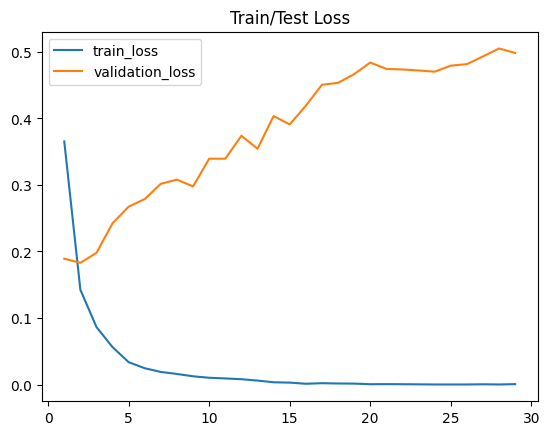

In [11]:
# plot train/test losses per epochs
train_loss = final_train_eval_metrics["train_loss"]
validation_loss = final_train_eval_metrics["validation_loss"]
epochs = [i for i in range(1, len(train_loss) + 1)]

plt.title("Train/Test Loss")
plt.plot(epochs, train_loss, label = "train_loss")
plt.plot(epochs, validation_loss, label = "validation_loss")
plt.legend()
plt.show()

In [22]:
# delete from your Google Drive saved checkpoints(if your want start fine-tuning process from scratch)
os.system(f"rm -r {Google_Drive_checkpoints_dir_path}/*")
# delete saved train-eval metrics on G-Drive
!rm /content/drive/MyDrive/DistilBERT_train_eval_metrics.csv
!rm -r fine_tuned_DistilBERT/*